# Classifying deceptive answers using keystrokes and linguistic cues

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn import preprocessing

In [3]:
os.getcwd()

'C:\\UNSYNCED\\workspace\\deception_language_production\\notebooks'

In [4]:
df = pd.pandas.read_csv("../data/final_features.csv")

In [5]:
# exclude columns that are not features
aux_columns = [
    'session_id',
    'response_box',
    'tag',
    'response',
    'truth',
    'prompt_id',
    'response_start',
    'response_finish',
    'version',
    'prompt',
]

In [6]:
features = list(set(df.columns) - set(aux_columns))

In [7]:
# number of samples
len(df)

266

In [8]:
# number of features
len(features)

68

In [9]:
df.fillna(-100, inplace=True)

In [10]:
#sesssion has only 2 responses
df = df[df.session_id != "17ddbab2-6d04-405b-afdb-37b992102569"] 

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df[features])
df[features] = scaler.transform(df[features])

## Standardize for between subject variation
To account for between subject variation, I use features from response 1 to standardize those of response 2 and 3 

In [12]:
df_resp1 = df.loc[df.response_box=='response1'].copy()
df_resp2 = df.loc[df.response_box=='response2'].copy()
df_resp3 = df.loc[df.response_box=='response3'].copy()

In [13]:
for i in features:
    df_resp2[i] = df_resp2[i].values - df_resp1[i].values
    df_resp3[i] = df_resp3[i].values - df_resp1[i].values

In [14]:
df = pd.concat([df_resp2, df_resp3], axis=0)

## Feature Selection

Use an extratreesclassifier to get the top N features.

Following the example here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [16]:
forest = ExtraTreesClassifier(n_estimators=5000)
forest.fit(df[features], df['truth'])

ExtraTreesClassifier(n_estimators=5000)

Feature ranking:
1. feature first_key_time (0.029681)
2. feature last_key_time (0.027561)
3. feature tri_flight_mean (0.019792)
4. feature di_flight_mean (0.019596)
5. feature flight_time_mean (0.019332)
6. feature ratio_first_plur_pro (0.018762)
7. feature tri_flight_std_dev (0.017883)
8. feature di_flight_skewness (0.017572)
9. feature ratio_PART (0.017481)
10. feature ratio_DET (0.017367)
11. feature ratio_unique_tokens (0.017228)
12. feature flight_time_skewness (0.017141)
13. feature ratio_CCONJ (0.017061)
14. feature ratio_SCONJ (0.017058)
15. feature di_flight_std_dev (0.017019)
16. feature ratio_ADP (0.016672)
17. feature time_before_first_key (0.016561)
18. feature tri_flight_skewness (0.016279)
19. feature avg_sentence_size (0.016258)
20. feature ratio_past_tense (0.016181)
21. feature ratio_NOUN (0.015790)
22. feature ratio_present_tense (0.015652)
23. feature ratio_total_discrete_errors (0.015606)
24. feature ratio_first_sin_pro (0.015381)
25. feature ratio_PRON (0.015303)


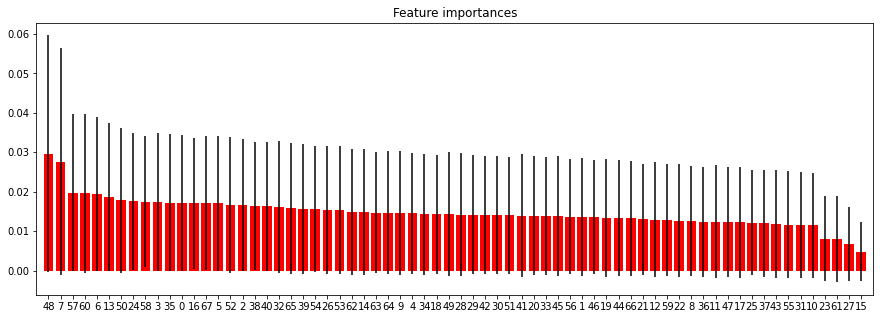

In [17]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

top_features = []
for idx, f in enumerate(range(len(features))):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    if idx < 10: # take the top 10 features
        top_features.append(features[indices[f]])

# Plot the feature importances of the forest
plt.figure(figsize=(15, 5))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(features)), indices)
plt.xlim([-1, len(features)])
plt.show()

In [18]:
from sklearn.metrics import zero_one_loss

# GradientBoostingClassifier performs better than RandomForestClassifier
params = {
    'n_estimators': 50, 'max_leaf_nodes': 10, 'max_depth': 4, 'random_state': 2,
    'min_samples_split': 5, 'learning_rate': 0.1, 'min_samples_leaf': 0.1}
cls = GradientBoostingClassifier

# params = {
#     'n_estimators': 50, 'max_leaf_nodes': 10, 'max_depth': 10, 'random_state': 2,
#     'min_samples_split': 5}
# cls = RandomForestClassifier

In [19]:
# patch in staged prediction for RandomForestClassifier

def staged_predict_proba(self, X):
    # staged_predict_proba for random forests
    y_proba = np.zeros((X.shape[0], 2), dtype=np.float64)
    for i, e in enumerate(self.estimators_):
        y_proba += e.predict_proba(X)
        yield y_proba / (i + 1)

def staged_predict(self, X):
    # staged_predict for random forests
    y_proba = np.zeros((X.shape[0], 2), dtype=np.float64)
    for i, e in enumerate(self.estimators_):
        y_proba += e.predict_proba(X)
        yield self.classes_.take(np.argmax(y_proba / (i + 1), axis=1), axis=0)
        
RandomForestClassifier.staged_predict = staged_predict
RandomForestClassifier.staged_predict_proba = staged_predict_proba

Train 100 models on 100 different train/test splits and then average performance metrics. We're dealing with a small sample here so this sampling approach will help approximate generalized performance on a larger sample

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.32it/s]


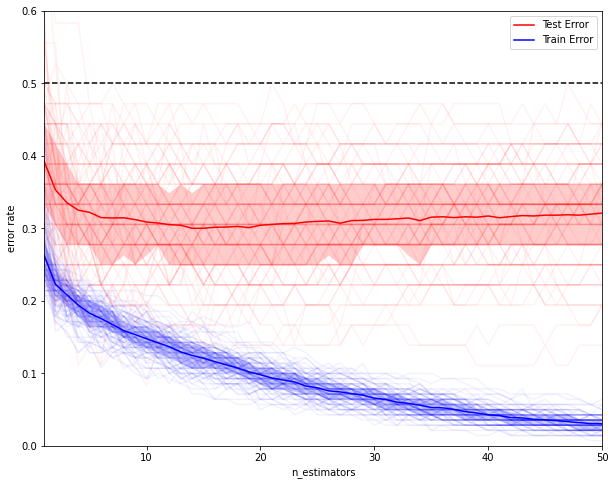

In [20]:
from scipy.stats import mstats

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

test_errs = []
train_errs = []

for i in tqdm(range(100)):

    df_train, df_test = train_test_split(df, test_size=0.2)
    
    clf = cls(**params)
    clf.fit(df_train[top_features], df_train['truth'])

    test_err = np.zeros((clf.n_estimators,))
    train_err = np.zeros((clf.n_estimators,))
    
    for i, y_pred in enumerate(clf.staged_predict(df_test[top_features])):
        test_err[i] = zero_one_loss(y_pred, df_test['truth'])
    for i, y_pred in enumerate(clf.staged_predict(df_train[top_features])):
        train_err[i] = zero_one_loss(y_pred, df_train['truth'])

    ax.plot(np.arange(clf.n_estimators) + 1, test_err,
            color='red', alpha=0.05)
    ax.plot(np.arange(clf.n_estimators) + 1, train_err,
            color='blue', alpha=0.05)
    
    test_errs.append(test_err)
    train_errs.append(train_err)
    
ax.plot(np.arange(clf.n_estimators) + 1, np.mean(test_errs, axis=0),
        label='Test Error',
        color='red')
ax.plot(np.arange(clf.n_estimators) + 1, np.mean(train_errs, axis=0),
        label='Train Error',
        color='blue')

test_quantiles = mstats.mquantiles(test_errs, axis=0)
train_quantiles = mstats.mquantiles(train_errs, axis=0)

ax.fill_between(np.arange(clf.n_estimators) + 1, test_quantiles[0], test_quantiles[2], facecolor='red', alpha=0.2)
ax.fill_between(np.arange(clf.n_estimators) + 1, train_quantiles[0], train_quantiles[2], facecolor='blue', alpha=0.2)

ax.axhline(0.5, linestyle='--', color='k')
ax.set_ylim((0.0, 0.6))
ax.set_xlim((1, clf.n_estimators))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')
ax.legend();
